# <u>U-NET: Pt II Electric Boogaloo Edition </u>

### Several years after having done this project, I have attempted to revisit this again, this time without all the older fluff, and whilst incorporating newer techniques to make the final result more reliable. So feel free to see how much has changed compared to the older variant!
### ====================================================================================

## <u>The imports </u>

#### Fun Fact: This did not used to be an issue in the older variant, but I have decided to keep it anyways as a precautionary tale: I used my GPU (*where my GTX1060 bois at*) for the entire notebook, and TensorFlow has a very ugly habit of preserving almost every bit of GPU RAM. Sounds fine until you realize feeding in data is not part of that reserve, and as a result will always hit an Out-Of-Memory Error due to there being like ~100MB open to do everything else. <br> This segment ensures that the session runs on "**dynamic allocation**", which means the GPU will only use as much RAM as is currently needed, scaling as it goes. (*Any alternative suggestions are greatly welcomed!*) 

In [1]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
set_session(session)

In [2]:
# Imports focusing on visualizing the data
import nibabel as nib
import nibabel.processing
import matplotlib.pyplot as plt # Currently has import error, solve first
from pprint import pprint
import pickle
import time

#Imports focusing on the model itself
import os
import asyncio
import numpy as np
import tensorflow as tf
import skimage.transform as skTrans
#----------
import keras
import tensorflow as tf

from keras import metrics
from functools import partial
from keras import backend as K
from keras.layers import Input, LeakyReLU, Add, Activation, SpatialDropout3D
from keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose, GlobalAveragePooling3D, concatenate
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten, Dense, PReLU

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

keras.backend.image_data_format()
K.set_image_data_format('channels_first')

## <u>The data loading </u>
#### Given that the task is purely segmentation (*I have forsaken the classification for another time*), data purely consists of the image files provided from the BraTS 2018 download link

In [3]:
HGG_dir_list = next(os.walk('./MICCAI_BraTS_2018_Data_Training/HGG/'))[1]
LGG_dir_list = next(os.walk('./MICCAI_BraTS_2018_Data_Training/LGG/'))[1]
# All training data
completelist2018 = HGG_dir_list + LGG_dir_list 
# All validation data
valid_list = next(os.walk('./MICCAI_BraTS_2018_Data_Validation/'))[1]

print(f'Training data of {len(completelist2018)} patients, {len(HGG_dir_list)} HGG + {len(LGG_dir_list)} LGG')

Training data of 285 patients, 210 HGG + 75 LGG


In [4]:
np.random.shuffle(completelist2018) 

partition={}

holdout_percentage=0.15
partition['holdout']=valid_list
trainlist=completelist2018

train_percentage=0.85
partition['train']=trainlist[0:int(len(trainlist)*train_percentage)]
partition['test']=trainlist[int(len(trainlist)*train_percentage):len(trainlist)]


labels={}
# HGG=0, LGG=1
for directory in HGG_dir_list:
    labels[directory]=0
for directory in LGG_dir_list:
    labels[directory]=1

print('Train:',len(completelist2018), '|| Test:', len(valid_list),'|| Labels:',len(labels))
print('Holdout:',partition['holdout'][:3])
print('Train:',partition['train'][:3])
print('Test:',partition['test'][:3])

print('Holdout:',len(partition['holdout']))
print('Train:',len(partition['train']))
print('Test:',len(partition['test']))

Train: 285 || Test: 66 || Labels: 285
Holdout: ['Brats18_CBICA_AAM_1', 'Brats18_CBICA_ABT_1', 'Brats18_CBICA_ALA_1']
Train: ['Brats18_CBICA_AZH_1', 'Brats18_TCIA13_653_1', 'Brats18_TCIA02_179_1']
Test: ['Brats18_2013_29_1', 'Brats18_TCIA08_469_1', 'Brats18_TCIA03_498_1']
Holdout: 66
Train: 242
Test: 43


In [5]:
file_dir = 'D:/BRaTs/BRATS_2018_Data/'
img_link = file_dir + '%s_images.pkl'
mask_link = file_dir + '%s_seg_mask_3ch.pkl'

# <u>File Preprocessing </u>

#### The original preprocessing method involved smoothing and downsampling each variant of a patient's scan image, before concatenating and padding to standardize the dimensions. This is then used to generate the appropriate multi-layer masks to then export as pickle files. This was done at the time to reduce the overall size of each input data to make it easier for the model to run and classify, cutting down model training time. 
#### What I didn't know, however, was that downsampling outright removes features of an image, making it kind of dangerous around small pixel-features. Instead, I opted to just concatenate and resize the image using *sci-kit image*'s package of transform: which not only resizes, but does interpolation to rescale features. This also meant, however, that the labels would rescale as well, needing specific value ranges as a cutoff prior to the usual `[0,1,2,4]`.

#### In addition, I have incorporated the use of `asyncio` to concurrently process the files, as there is no need to wait for one patient's files to finish before beginning another. 

In [6]:
async def concat_imgs(imgs, ID):
    # Concatenate
    newimg = nib.concat_images(imgs)
    '''New method: Resizing, Rescaling, Interpolating and Anti-Aliasing'''
    img_array = np.array(newimg.dataobj)
    z = np.rollaxis(img_array, 3, 0)
    new_img = skTrans.resize(z, (5,128,128,128), order=1, preserve_range=True, anti_aliasing=True)
    
    a,b,c,d,seg_mask = np.split(new_img, 5, axis=0)
    images = np.concatenate([a,b,c,d], axis=0)

    full_mask = core_mask = enhance_mask = np.copy(seg_mask)
    seg_mask_1 = seg_mask_2 = seg_mask_3 = np.zeros((1,128,128,128))
    
    '''P.S: Tumor Core is always in Enhancing Tumor, which is always in Edema'''
    # Edema can basically be entire whole tumor outline
    seg_mask_1 = np.where(full_mask!=0, 1, full_mask) 
    # Whole Tumor without edema is the tumor core
    seg_mask_2 = np.where(enhance_mask<=2.2, 0, enhance_mask)
    seg_mask_2 = np.where(seg_mask_2 !=0, 2, seg_mask_2) 
    # Tumor core without enchaning tumor is just the necrotic tissue
    seg_mask_3 = np.where(core_mask >1.2, 0, core_mask)
    seg_mask_3 = np.where(seg_mask_3 <0.9, 0, seg_mask_3)
    seg_mask_3 = np.where(seg_mask_3 !=0, 4, seg_mask_3)
    
    
    
    seg_mask_3ch = np.concatenate([seg_mask_1,seg_mask_2,seg_mask_3], axis=0).astype(int)

    pickle.dump( images, open( img_link%(ID), "wb" ) )
    pickle.dump( seg_mask_3ch, open( mask_link%(ID), "wb" ) )

async def main():
    start = time.time()
    dict_X =  {'img1':'flair', 'img2': 't1', 'img3':'t1ce', 'img4':'t2', 'img5':'seg'}
    tasks = []
    for i, ID in enumerate(completelist2018):
        group = 'HGG' if ID in HGG_dir_list else 'LGG' if ID in LGG_dir_list else None
    
        imgs = []
        print(f'{i} of {len(completelist2018)}, {ID}') # Debug
        for key, value in dict_X.items():
            file_link = f'./MICCAI_BraTS_2018_Data_Training/{group}/{ID}/{ID}_{value}.nii.gz'
            file_img = nib.load(file_link)
            imgs.append(file_img)
        concat_task = asyncio.create_task(concat_imgs(imgs, ID))
        tasks.append(concat_task)
        
    results = await asyncio.gather(*tasks)
    end = time.time()
    print(f'Total time to process entire dataset: {end-start}') 

#### As of the time of writing this operation, the entire process took 18 minutes to complete, compared to the original version of 2 hours. The combination of async operations to run multiple processes in parallel, in conjunction with the fact that most processes can be cut down or out entirely has saved plenty of time, but there is always more than can be done (*in the future*)

In [8]:
results = await main()

0 of 285, Brats18_CBICA_AZH_1
1 of 285, Brats18_TCIA13_653_1
2 of 285, Brats18_TCIA02_179_1
3 of 285, Brats18_CBICA_AOP_1
4 of 285, Brats18_CBICA_AQZ_1
5 of 285, Brats18_TCIA03_474_1
6 of 285, Brats18_2013_11_1
7 of 285, Brats18_TCIA02_605_1
8 of 285, Brats18_CBICA_ATV_1
9 of 285, Brats18_CBICA_AYI_1
10 of 285, Brats18_CBICA_AZD_1
11 of 285, Brats18_TCIA10_442_1
12 of 285, Brats18_TCIA05_396_1
13 of 285, Brats18_CBICA_AQQ_1
14 of 285, Brats18_TCIA10_175_1
15 of 285, Brats18_CBICA_AQV_1
16 of 285, Brats18_CBICA_BHK_1
17 of 285, Brats18_TCIA01_425_1
18 of 285, Brats18_CBICA_ALN_1
19 of 285, Brats18_TCIA01_231_1
20 of 285, Brats18_CBICA_ASV_1
21 of 285, Brats18_2013_19_1
22 of 285, Brats18_TCIA03_296_1
23 of 285, Brats18_TCIA10_632_1
24 of 285, Brats18_2013_8_1
25 of 285, Brats18_TCIA03_375_1
26 of 285, Brats18_CBICA_ABO_1
27 of 285, Brats18_TCIA01_401_1
28 of 285, Brats18_TCIA02_377_1
29 of 285, Brats18_TCIA03_199_1
30 of 285, Brats18_CBICA_APY_1
31 of 285, Brats18_2013_15_1
32 of 285, B

258 of 285, Brats18_TCIA04_361_1
259 of 285, Brats18_TCIA13_623_1
260 of 285, Brats18_TCIA02_368_1
261 of 285, Brats18_TCIA01_448_1
262 of 285, Brats18_TCIA13_645_1
263 of 285, Brats18_TCIA12_466_1
264 of 285, Brats18_TCIA10_330_1
265 of 285, Brats18_2013_26_1
266 of 285, Brats18_CBICA_ASK_1
267 of 285, Brats18_TCIA01_131_1
268 of 285, Brats18_CBICA_AAP_1
269 of 285, Brats18_TCIA09_451_1
270 of 285, Brats18_2013_18_1
271 of 285, Brats18_TCIA08_105_1
272 of 285, Brats18_TCIA02_608_1
273 of 285, Brats18_TCIA01_429_1
274 of 285, Brats18_TCIA02_314_1
275 of 285, Brats18_CBICA_ABE_1
276 of 285, Brats18_2013_27_1
277 of 285, Brats18_TCIA13_650_1
278 of 285, Brats18_TCIA10_490_1
279 of 285, Brats18_TCIA09_462_1
280 of 285, Brats18_TCIA02_151_1
281 of 285, Brats18_CBICA_AVJ_1
282 of 285, Brats18_CBICA_ABY_1
283 of 285, Brats18_2013_24_1
284 of 285, Brats18_TCIA02_118_1
Total time to process entire dataset: 1112.824939250946


# Debug Processing output

#### Current layers for the mask has also changed: before, it used to be just 3 layers: all 1, all 2, all 4. Now, I have opted to change it such that one layer has the entire ROI as the edema, the entire core for enhancing, and the necrotic tissue as the tumor core.

In [158]:
ID = partition['train'][117]
print(ID)
group = 'HGG' if ID in HGG_dir_list else 'LGG' if ID in LGG_dir_list else None
file_link = f'./BRATS_2018_Data/{ID}_seg_mask_3ch.pkl'
# print(file_link)
seg_link = f'./MICCAI_BraTS_2018_Data_Training/{group}/{ID}/{ID}_seg.nii.gz'
# print(seg_link)

PKL = pickle.load(open((file_link), "rb"))
PKL_0, PKL_1, PKL_2 = np.split(PKL, 3, axis=0)
PKL_full = PKL_0 + PKL_1 + PKL_2
NII_0 = nib.load(seg_link)
NII_0 = skTrans.resize(NII_0.get_fdata(), (128,128,128), order=1, preserve_range=True, anti_aliasing=True)

Brats18_TCIA10_408_1
(128, 128, 128) (128, 128, 128)


<Figure size 640x480 with 0 Axes>

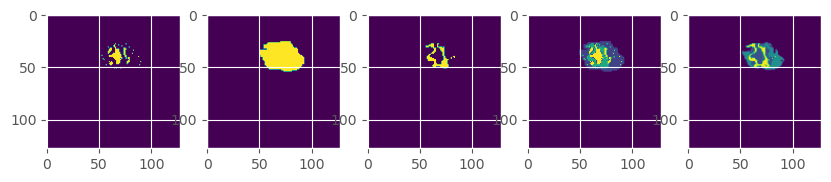

In [163]:
'''Segment to print out figures'''
dim_slice = 40
plt.figure()
f1, axarr1 = plt.subplots(1,5, figsize=(10,10)) 
axarr1[0].imshow(PKL_2[0][:,:,dim_slice]) 
axarr1[1].imshow(PKL_0[0][:,:,dim_slice]) 
axarr1[2].imshow(PKL_1[0][:,:,dim_slice]) 
axarr1[3].imshow(PKL_full[0][:,:,dim_slice])
axarr1[4].imshow(NII_0[:,:,dim_slice])

## Model
#### The data generator and model is identical to before, with the minor change of the input dimensions matching `(128,128,128)` instead of the original `(240,240,155)` or the old downsampled variant of `(80,96,80)`. I chose them all as 128 since it matches the power 2, which is because *honestly everytime I tried changing the sizes some error would occur in the process of deconvolution and leaky Relu regarding dimension mismatch, which doesn't happen if its the power 2 so.....heuristic*

In [22]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=2, dim=(240,240,155), n_channels=4, n_classes=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y1 = self.__data_generation(list_IDs_temp)
        return X, y1

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        # Initialization
        X = np.empty((self.batch_size, self.n_channels, *self.dim))
        y1 = np.empty((self.batch_size, 3, *self.dim))

        # Generate data
        # Decode and load the data
        for i, ID in enumerate(list_IDs_temp):
            #(TC = Tumor core, ED = edema, ET = enhancing tumor)
            X[i,] = pickle.load( open( img_link%(ID), "rb" ) )
            y1[i,] = pickle.load( open( mask_link%(ID), "rb" ) )
        return X, y1

In [16]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False, kernel=(3, 3, 3), activation=None,
                             padding='same', strides=(1, 1, 1), instance_normalization=False):
    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    if batch_normalization:
        layer = BatchNormalization(axis=1)(layer)
    elif instance_normalization:
        try:
            from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
        except ImportError:
            raise ImportError("Install keras_contrib in order to use instance normalization."
                              "\nTry: pip install git+https://www.github.com/farizrahman4u/keras-contrib.git")
        layer = InstanceNormalization(axis=1)(layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)

def compute_level_output_shape(n_filters, depth, pool_size, image_shape):
    output_image_shape = np.asarray(np.divide(image_shape, np.power(pool_size, depth)), dtype=np.int32).tolist()
    return tuple([None, n_filters] + output_image_shape)

def get_up_convolution(n_filters, pool_size, kernel_size=(2, 2, 2), strides=(2, 2, 2), deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size,
                               strides=strides)
    else:
        return UpSampling3D(size=pool_size)

def create_localization_module(input_layer, n_filters):
    convolution1 = create_convolution_block(input_layer, n_filters)
    convolution2 = create_convolution_block(convolution1, n_filters, kernel=(1, 1, 1))
    return convolution2

def create_up_sampling_module(input_layer, n_filters, size=(2, 2, 2)):
    up_sample = UpSampling3D(size=size)(input_layer)
    convolution = create_convolution_block(up_sample, n_filters)
    return convolution

def create_context_module(input_layer, n_level_filters, dropout_rate=0.3, data_format="channels_first"):
    convolution1 = create_convolution_block(input_layer=input_layer, n_filters=n_level_filters)
    dropout = SpatialDropout3D(rate=dropout_rate, data_format=data_format)(convolution1)
    convolution2 = create_convolution_block(input_layer=dropout, n_filters=n_level_filters)
    return convolution2

create_convolution_block = partial(create_convolution_block, activation=LeakyReLU, instance_normalization=True)

In [17]:
def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

def weighted_dice_coefficient(y_true, y_pred, axis=(-3, -2, -1), smooth=0.00001):
    return K.mean(2.*(K.sum(y_true*y_pred,axis=axis)+smooth/2)/(K.sum(y_true,axis=axis)+K.sum(y_pred,axis=axis)+smooth))

def weighted_dice_coefficient_loss(y_true, y_pred):
    return -weighted_dice_coefficient(y_true, y_pred)

def label_wise_dice_coefficient(y_true, y_pred, label_index):
    return dice_coefficient(y_true[:, label_index], y_pred[:, label_index])

def get_label_dice_coefficient_function(label_index):
    f = partial(label_wise_dice_coefficient, label_index=label_index)
    f.__setattr__('__name__', 'label_{0}_dice_coef'.format(label_index))
    return f

def mean_iou(y_true, y_pred):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
            prec.append(score)
        return K.mean(K.stack(prec), axis=0)

dice_coef = dice_coefficient
dice_coef_loss = dice_coefficient_loss

In [18]:
input_shape=(4, 128, 128, 128)
n_base_filters=8
depth=4
dropout_rate=0.2
n_segmentation_levels=3
n_labels=3
activation_name="sigmoid"

inputs = Input(input_shape)


#Segmentation
current_layer = inputs
level_output_layers = list()
level_filters = list()
for level_number in range(depth):
    n_level_filters = (2**level_number) * n_base_filters
    level_filters.append(n_level_filters)

    if current_layer is inputs:
        in_conv = create_convolution_block(current_layer, n_level_filters)
    else:
        in_conv = create_convolution_block(current_layer, n_level_filters, strides=(2, 2, 2))

    context_output_layer = create_context_module(in_conv, n_level_filters, dropout_rate=dropout_rate)

    summation_layer = Add()([in_conv, context_output_layer])
    level_output_layers.append(summation_layer)
    current_layer = summation_layer

segmentation_layers = list()
for level_number in range(depth - 2, -1, -1):
    up_sampling = create_up_sampling_module(current_layer, level_filters[level_number])
    concatenation_layer = concatenate([level_output_layers[level_number], up_sampling], axis=1)
    localization_output = create_localization_module(concatenation_layer, level_filters[level_number])
    current_layer = localization_output
    if level_number < n_segmentation_levels:
        segmentation_layers.insert(0, create_convolution_block(current_layer, n_filters=n_labels, kernel=(1, 1, 1)))

output_layer = None
for level_number in reversed(range(n_segmentation_levels)):
    segmentation_layer = segmentation_layers[level_number]
    if output_layer is None:
        output_layer = segmentation_layer
    else:
        output_layer = Add()([output_layer, segmentation_layer])

    if level_number > 0:
        output_layer = UpSampling3D(size=(2, 2, 2))(output_layer)

activation_block = Activation(activation = activation_name, name='activation_block')(output_layer)

In [19]:
model = tf.keras.Model(inputs=inputs, outputs=[activation_block])
# model2.load_weights("./weights/model_2_weights.h5", by_name=True) 

model.compile(optimizer=RMSprop(lr=0.01), 
              loss={'activation_block': weighted_dice_coefficient_loss}, 
              loss_weights={'activation_block': 1.},
              metrics={'activation_block': ['accuracy',weighted_dice_coefficient, dice_coefficient]})

model.summary(line_length=150)

Model: "model"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 4, 128, 128, 128)]       0                 []                                                
                                                                                                                                                      
 conv3d (Conv3D)                                 (None, 8, 128, 128, 128)         872               ['input_1[0][0]']                                 
                                                                                                                                                      
 instance_normalization (InstanceNormalization)  (None, 8, 128, 128, 128)      

                                                                                                                                                      
 conv3d_6 (Conv3D)                               (None, 32, 32, 32, 32)           13856             ['add_1[0][0]']                                   
                                                                                                                                                      
 instance_normalization_6 (InstanceNormalization  (None, 32, 32, 32, 32)          64                ['conv3d_6[0][0]']                                
 )                                                                                                                                                    
                                                                                                                                                      
 leaky_re_lu_6 (LeakyReLU)                       (None, 32, 32, 32, 32)           0           

 conv3d_12 (Conv3D)                              (None, 32, 32, 32, 32)           55328             ['up_sampling3d[0][0]']                           
                                                                                                                                                      
 instance_normalization_12 (InstanceNormalizatio  (None, 32, 32, 32, 32)          64                ['conv3d_12[0][0]']                               
 n)                                                                                                                                                   
                                                                                                                                                      
 leaky_re_lu_12 (LeakyReLU)                      (None, 32, 32, 32, 32)           0                 ['instance_normalization_12[0][0]']               
                                                                                              

C:\Users\recon\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


                                                                                                                                                      
 instance_normalization_16 (InstanceNormalizatio  (None, 16, 64, 64, 64)          32                ['conv3d_16[0][0]']                               
 n)                                                                                                                                                   
                                                                                                                                                      
 leaky_re_lu_16 (LeakyReLU)                      (None, 16, 64, 64, 64)           0                 ['instance_normalization_16[0][0]']               
                                                                                                                                                      
 concatenate_1 (Concatenate)                     (None, 32, 64, 64, 64)           0           

                                                                                                                                                      
 instance_normalization_19 (InstanceNormalizatio  (None, 3, 64, 64, 64)           6                 ['conv3d_19[0][0]']                               
 n)                                                                                                                                                   
                                                                                                                                                      
 leaky_re_lu_22 (LeakyReLU)                      (None, 8, 128, 128, 128)         0                 ['instance_normalization_22[0][0]']               
                                                                                                                                                      
 up_sampling3d_3 (UpSampling3D)                  (None, 3, 64, 64, 64)            0           

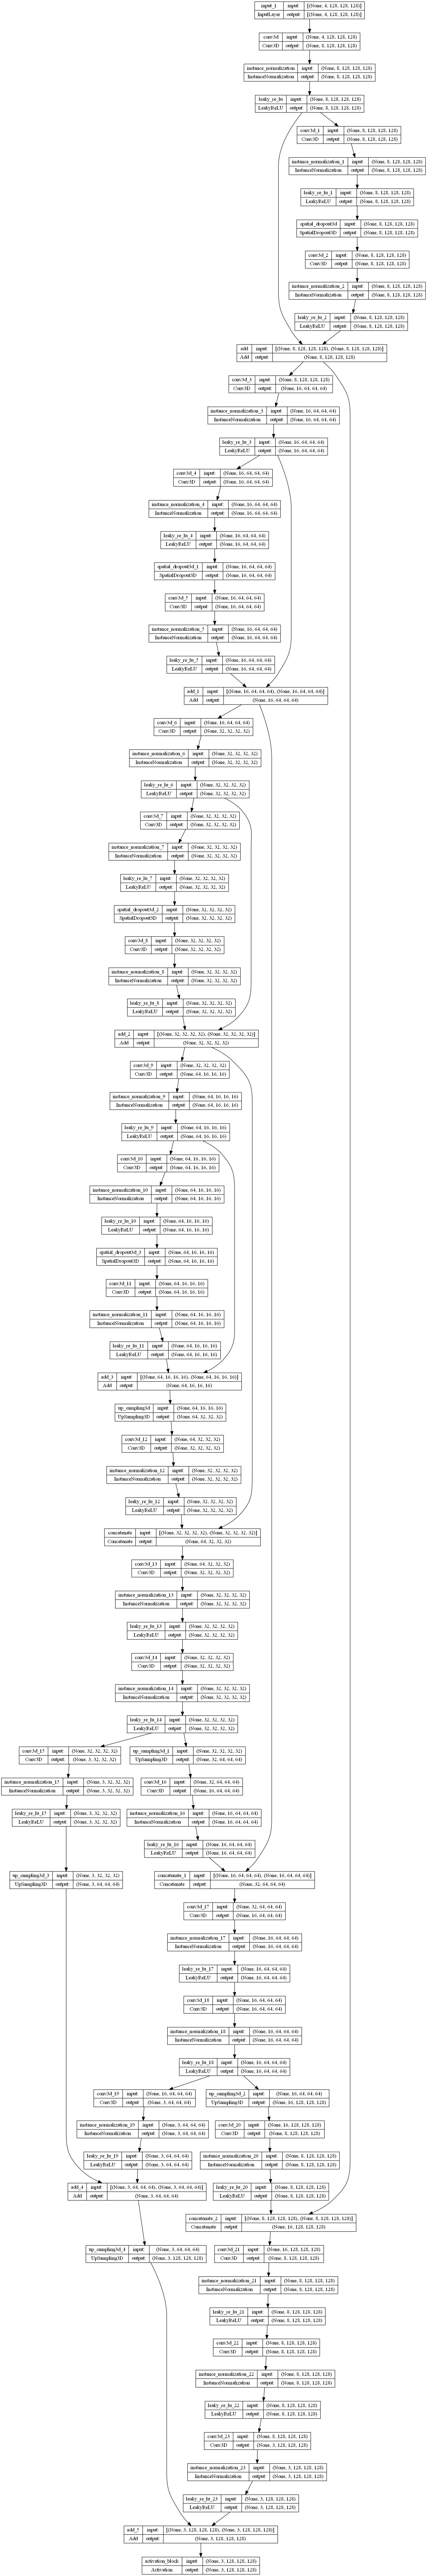

In [20]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='unet.jpeg', show_shapes=True, show_layer_names=True)

## <u>Model Training </u>
#### The only real change done were to the hyperparameters, as well as the syntax of calling the model to fit. The batch size and `workers` was reduced primarily to avoid the OOM errors and maximize performance, at the cost of training being 2 hours (*lol*). The number of identifiable classes was reduced to 3, since in `[0,1,2,4]`, 0 is the background and is not considered. The dimensions were shifted as mentioned earlier.

In [23]:
params = {'dim': (128,128,128),
          'batch_size': 1,
          'n_classes': 3,
          'n_channels': 4,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition['train'], **params)
validation_generator = DataGenerator(partition['test'], **params)

cb_1=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
cb_2=keras.callbacks.ModelCheckpoint(filepath="./weights/2pred_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', 
                                     verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')


results = model.fit(x=training_generator, 
                    validation_data=validation_generator,
                    epochs=10, 
                    workers=1,
                    callbacks=[cb_1,cb_2])
model.save("./model/model.hdf5")
model.save_weights("./weights/model_weights.h5")
print("Saved model to disk")

Epoch 1/10
242/242 [==============================] - 346s 1s/step - loss: -0.0770 - accuracy: 0.2699 - weighted_dice_coefficient: 0.0770 - dice_coefficient: 0.0751 - val_loss: -0.1378 - val_accuracy: 0.0165 - val_weighted_dice_coefficient: 0.1378 - val_dice_coefficient: 0.1304
Epoch 2/10
242/242 [==============================] - 319s 1s/step - loss: -0.2323 - accuracy: 0.1819 - weighted_dice_coefficient: 0.2323 - dice_coefficient: 0.2269 - val_loss: -0.3524 - val_accuracy: 0.0347 - val_weighted_dice_coefficient: 0.3524 - val_dice_coefficient: 0.3573
Epoch 3/10
242/242 [==============================] - 320s 1s/step - loss: -0.4256 - accuracy: 0.1935 - weighted_dice_coefficient: 0.4256 - dice_coefficient: 0.4568 - val_loss: -0.5403 - val_accuracy: 0.0271 - val_weighted_dice_coefficient: 0.5403 - val_dice_coefficient: 0.6067
Epoch 4/10
242/242 [==============================] - 322s 1s/step - loss: -0.5545 - accuracy: 0.0928 - weighted_dice_coefficient: 0.5545 - dice_coefficient: 0.629

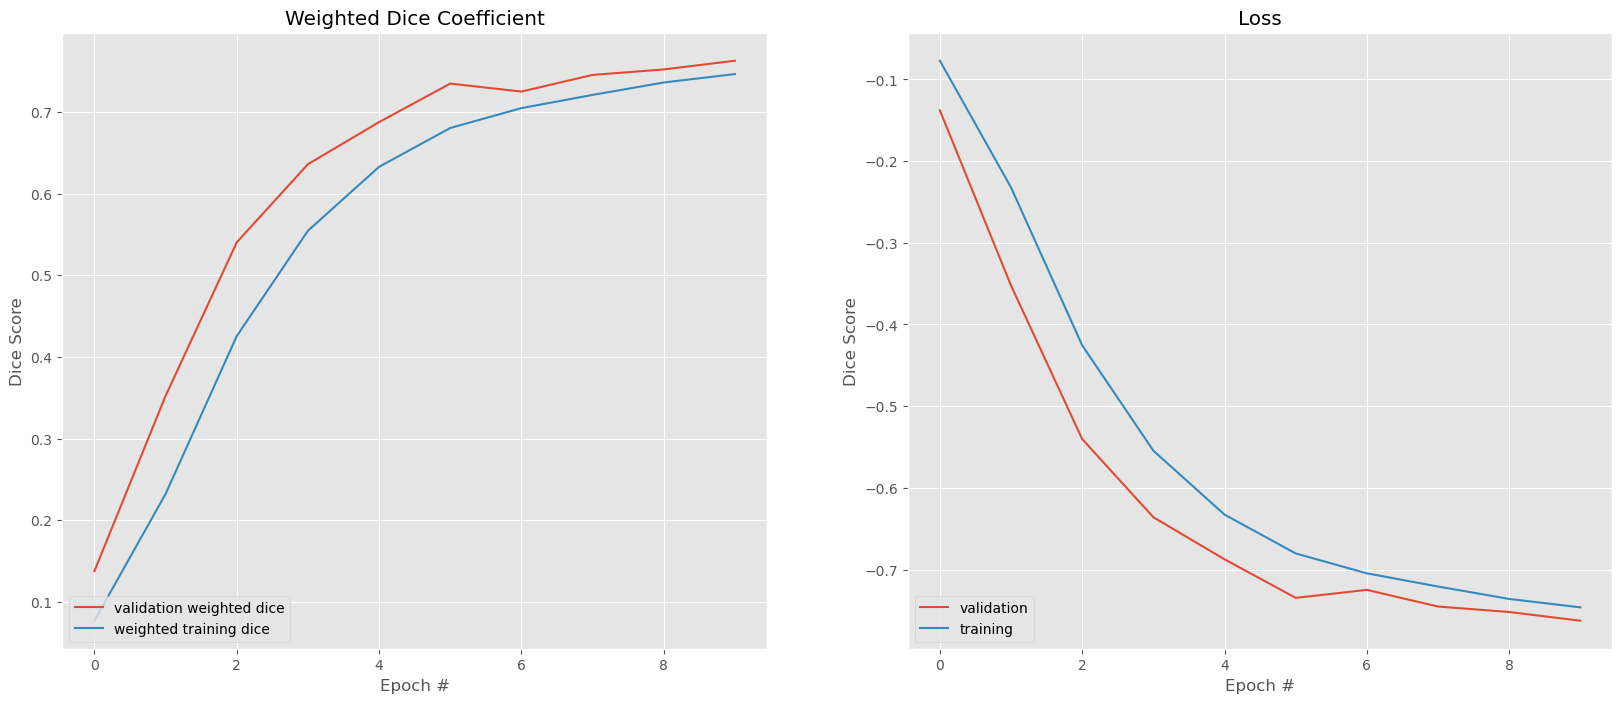

In [24]:
# Purely for graph plotting
history_pred = results.history
pickle.dump( history_pred, open( "./weights/history_pred.pkl", "wb" ) )

# Comment out/in as needed to load the pickle file
history_pred = pickle.load(open( "./weights/history_pred.pkl", "rb"))
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))
titlemetric = ['Weighted Dice Coefficient', 'Loss']

for i in range(1,3):
    fig.add_subplot(1,2,i)
    plt.title(titlemetric[i-1])
    if(i-1==0):
        plt.plot(history_pred['val_weighted_dice_coefficient'], label='validation weighted dice')
        plt.plot(history_pred['weighted_dice_coefficient'], label = 'weighted training dice')
    else:
        plt.plot(history_pred['val_loss'], label='validation')
        plt.plot(history_pred['loss'], label = 'training')
    plt.xlabel("Epoch #")
    plt.ylabel("Dice Score")
    plt.legend(loc="lower left")

## <u>Model Prediction </u>
#### It has come to my attention that I did not find a way to produce some form of performance metric to indicate how well it did in the past, so I will probably come back to this in the future to add one. Until then, I have added a visual plot below to indicate it's accuracy. (*admittedly it's lacking some, but this was done in only 10 epochs and could be expanded upon further*)

In [25]:
params = {'dim': (128,128,128),
          'batch_size': 1,
          'n_classes': 3,
          'n_channels': 4,
          'shuffle': False}

# Turned shuffle off so that we can match the values in the dictionary to the predictions. 
# This way we can compare the predictions side-by-side with the ground truth.

validation_generator = DataGenerator(partition['test'], **params)

predictions_pred = model.predict_generator(generator=validation_generator)

pickle.dump( predictions_pred, open( "./weights/predictions_pred.pkl", "wb" ) )
predictions_pred

C:\Users\recon\AppData\Local\Temp\ipykernel_5816\1426808091.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_pred = model.predict_generator(generator=validation_generator)


array([[[[[7.30886313e-05, 1.48104746e-05, 1.92040770e-05, ...,
           1.64634257e-05, 1.65777601e-05, 6.95156123e-05],
          [1.37298466e-05, 1.06570242e-05, 1.42018425e-05, ...,
           1.20620916e-05, 1.16586189e-05, 1.53265755e-05],
          [1.57099876e-05, 1.30393701e-05, 1.58059393e-05, ...,
           1.25991101e-05, 1.42485360e-05, 1.83143839e-05],
          ...,
          [1.37896322e-05, 1.11782947e-05, 1.32311488e-05, ...,
           1.09652783e-05, 1.26856876e-05, 1.63030309e-05],
          [1.12502903e-05, 8.63277455e-06, 1.06376192e-05, ...,
           9.11905772e-06, 9.19436570e-06, 1.18748958e-05],
          [3.62693718e-05, 9.62185277e-06, 1.03935990e-05, ...,
           9.10872313e-06, 9.21046103e-06, 3.55846096e-05]],

         [[2.66257375e-05, 1.42892241e-05, 1.70922267e-05, ...,
           1.45681033e-05, 1.49598372e-05, 2.25804961e-05],
          [1.54931204e-05, 1.97944046e-05, 2.30770438e-05, ...,
           1.94287022e-05, 1.96273140e-05, 1.483330

## Debug: Show model output

In [143]:
print(len(partition['test'])) #43
ID_num = 6
ID = partition['test'][ID_num]
group = 'HGG' if ID in HGG_dir_list else 'LGG' if ID in LGG_dir_list else None
file_link = f'./MICCAI_BraTS_2018_Data_Training/{group}/{ID}/{ID}_seg.nii.gz'
file_img = nib.load(file_link)
file_data = file_img.get_fdata()
z = np.rollaxis(file_data, 2, 0)
new_img = skTrans.resize(z, (128,128,128), order=1, preserve_range=True, anti_aliasing=True)

43


In [144]:
pred0, pred1, pred2 = np.split(predictions_pred[ID_num], 3, axis=0)
pred0 = pred0[0]
pred1 = pred1[0]
pred2 = pred2[0]
print(predictions_pred[14].shape, pred0.shape, pred1.shape, pred2.shape)

(3, 128, 128, 128) (128, 128, 128) (128, 128, 128) (128, 128, 128)


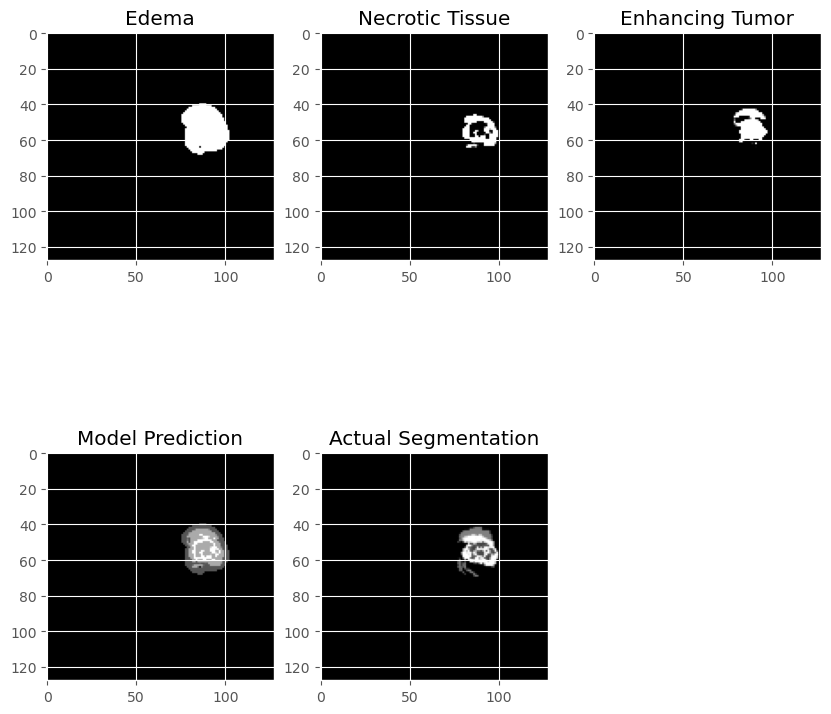

In [145]:
predmod0 = np.where(pred0 >0.9, 1, pred0)
predmod0 = np.where(predmod0!=1, 0, predmod0)
predmod1 = np.where(pred1>0.9, 1, pred1)
predmod2 = np.where(pred2>0.9, 1, pred2)

predmodwhole = predmod0+predmod1+predmod2
predwhole = pred0 + pred1 + pred2

fig = plt.figure(figsize=(10,10))
dim_Z = 70
imlist = [predmod0[:,:,dim_Z],predmod1[:,:,dim_Z],predmod2[:,:,dim_Z], predmodwhole[:,:,dim_Z], new_img[dim_Z,:,:]]
imname = ['Edema','Necrotic Tissue', 'Enhancing Tumor', 'Model Prediction', 'Actual Segmentation']

j = 0
for i in range(1, 6):
    fig.add_subplot(2,3, i)
    plt.gca().set_title(imname[j])
    plt.imshow(imlist[j], cmap='gray')
    j += 1